In [1]:
import numpy as np
from desisim.spec_qa import redshifts as dsq_z
import astropy.table
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
froot = '/project/projectdirs/desi/datachallenge/reference_runs/19.2/'
f_truth = froot + 'targets/truth.fits'
f_zcata = froot + 'spectro/redux/mini/zcatalog-mini.fits'

In [3]:
truth = Table.read(f_truth, 'TRUTH')
truth_elg = Table.read(f_truth, 'TRUTH_ELG')

zcat = Table.read(f_zcata)

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

#### Merge truth_elg info into truth, for true ELGs

In [4]:
np.intersect1d(truth.colnames, truth_elg.colnames)

array(['TARGETID'],
      dtype='<U15')

In [5]:
del truth_elg.meta['EXTNAME']
truth = astropy.table.join(truth, truth_elg, join_type='left', keys='TARGETID')

#### Pick out same targets in zcatalog and truth

In [6]:
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']

In [7]:
np.intersect1d(truth.colnames, zcat.colnames)

array(['FLUX_G', 'FLUX_R', 'FLUX_W1', 'FLUX_W2', 'FLUX_Z', 'TARGETID'],
      dtype='<U33')

In [8]:
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

#### Peek true numbers of different targets

In [9]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3110
LRG  5069
ELG  15585
STAR 3536
BGS  14672


In [10]:
print(set(ztruth['TRUESPECTYPE']))
print(set(ztruth['TEMPLATETYPE']))

{'QSO', 'WD', 'STAR', 'GALAXY'}
{'ELG', 'STAR', 'WD', 'LRG', 'QSO', 'BGS'}


#### True vs Redrock

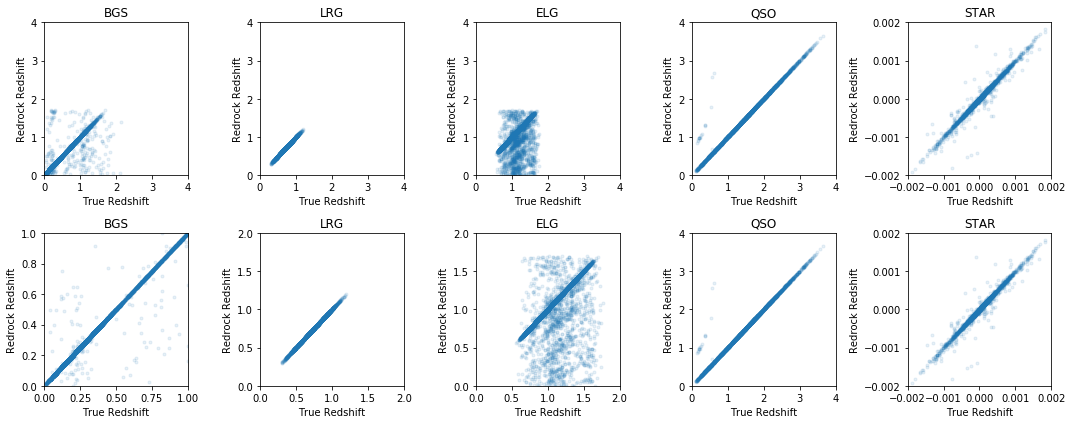

In [11]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5):
    plt.plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    plt.title(label)
    plt.xlim(zmin, zmax); plt.ylim(zmin, zmax)
    plt.xlabel('True Redshift')
    plt.ylabel('Redrock Redshift')

plt.figure(figsize=(15,6))
plt.subplot(251); plotz(ztruth[isBGS], 'BGS', zmax=4)
plt.subplot(252); plotz(ztruth[isLRG], 'LRG', zmax=4)
plt.subplot(253); plotz(ztruth[isELG], 'ELG', zmax=4)
plt.subplot(254); plotz(ztruth[isQSO], 'QSO', zmax=4)
plt.subplot(255); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

plt.subplot(256); plotz(ztruth[isBGS], 'BGS', zmax=1)
plt.subplot(257); plotz(ztruth[isLRG], 'LRG', zmax=2)
plt.subplot(258); plotz(ztruth[isELG], 'ELG', zmax=2)
plt.subplot(259); plotz(ztruth[isQSO], 'QSO', zmax=4)
plt.subplot(2,5,10); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)

plt.tight_layout()

In [12]:
truth.colnames

['TARGETID',
 'MOCKID',
 'TRUEZ',
 'TRUESPECTYPE',
 'TEMPLATETYPE',
 'TEMPLATESUBTYPE',
 'TEMPLATEID',
 'SEED',
 'MAG',
 'MAGFILTER',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'OIIFLUX',
 'HBETAFLUX',
 'EWOII',
 'EWHBETA',
 'D4000',
 'VDISP',
 'OIIDOUBLET',
 'OIIIHBETA',
 'OIIHBETA',
 'NIIHBETA',
 'SIIHBETA',
 'TRUEZ_NORSD']

In [13]:
# remove TARGETID=-1 of unassigned fibers
assigned = zcat['TARGETID'] >= 0
dsq_z.match_truth_z(truth, zcat[assigned], mini_read=True)

In [14]:
truth.colnames

['TARGETID',
 'MOCKID',
 'TRUEZ',
 'TRUESPECTYPE',
 'TEMPLATETYPE',
 'TEMPLATESUBTYPE',
 'TEMPLATEID',
 'SEED',
 'MAG',
 'MAGFILTER',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'OIIFLUX',
 'HBETAFLUX',
 'EWOII',
 'EWHBETA',
 'D4000',
 'VDISP',
 'OIIDOUBLET',
 'OIIIHBETA',
 'OIIHBETA',
 'NIIHBETA',
 'SIIHBETA',
 'TRUEZ_NORSD',
 'Z',
 'ZERR',
 'ZWARN',
 'SPECTYPE',
 'DESI_TARGET']

In [15]:
print('          ntarg   good  fail  miss  lost')
for objtype in set(truth['TEMPLATETYPE']):
    #isx = (truth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost, nx = dsq_z.zstats(truth, objtype=objtype)
    #nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift and ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift and ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
ELG       17204   80.9   0.6   8.2  10.2
STAR       3536   89.1   0.5   2.9   7.5
WD           97  100.0   0.0   0.0   0.0
LRG        5203  100.0   0.0   0.0   0.0
QSO_L       572  100.0   0.0   0.0   0.0
QSO_T      4730   92.8   0.5   2.2   4.5
BGS       12905   97.0   0.1   1.7   1.1

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift and ZWARN!=0 (missed opportunities)
lost = wrong redshift and ZWARN!=0 (wrong but at least we know it)


### Criteria for good, fail, miss and lost

#### dv criteria

#### ELG flux limit